# hello 我们来看一下最难的数学问题。
感谢勇哥带给我们的hint。[MathPrompter: Mathematical Reasoning using Large Language Models](https://arxiv.org/abs/2303.05398)的思路如下：
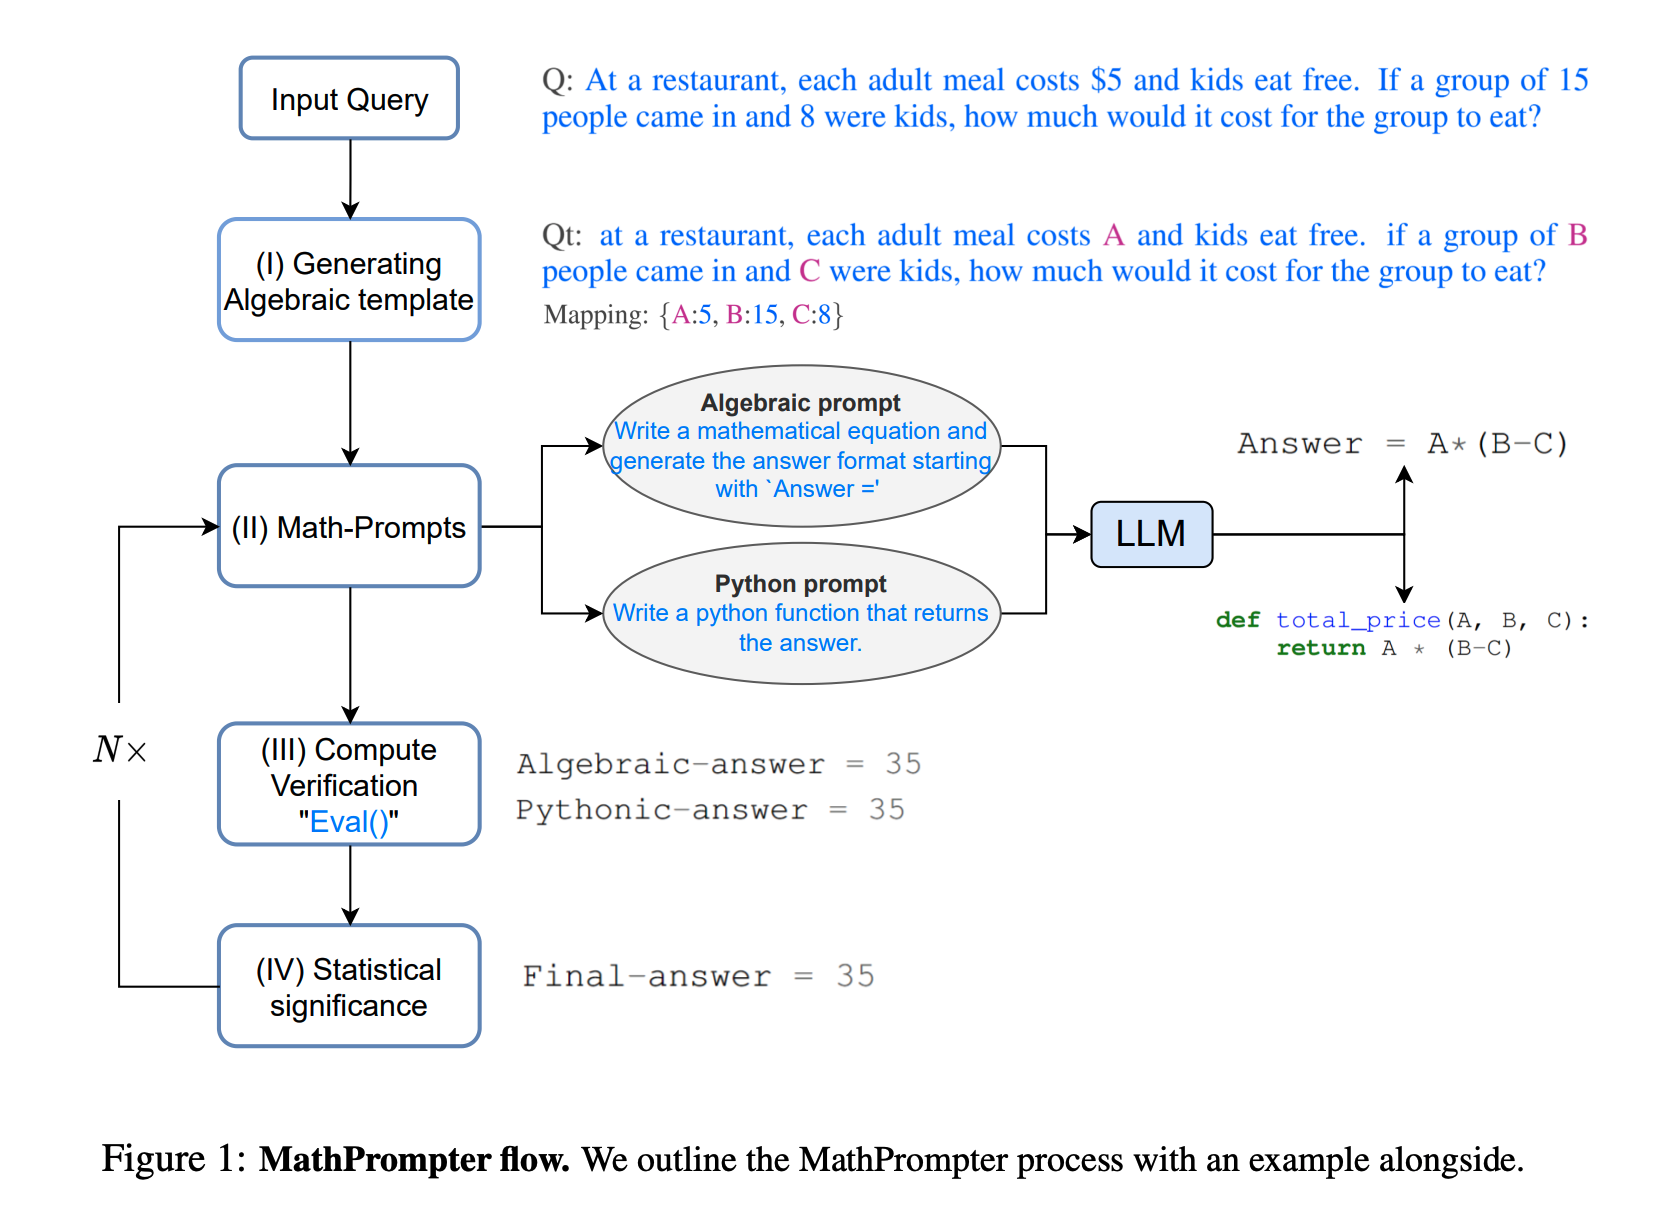
通过CoT与algebra+python交叉验证的方式，以及类似的案例引用(few shot)，sonnet可以快速提升准确性。

案例中的问题来源于TAL，感谢用户的输入！

Best

In [5]:
# 直接输入是错误的

from langchain_community.chat_models import BedrockChat
from langchain_core.messages import HumanMessage

chat = BedrockChat(model_id="anthropic.claude-3-sonnet-20240229-v1:0", model_kwargs={"temperature": 0.1})
q = '小明家距离学校3公里，早晨出门走了1公里发现忘带橡皮，回家取了橡皮再出发，然后走了2公里发现忘带铅笔，回家取了铅笔后再出发到达学校，下午放学回家。问小明今天走了多远？'

messages = [
    HumanMessage(
        content=q
    )
]
chat(messages)

AIMessage(content='为了解决这个问题,我们需要计算小明从家到学校和从学校回家的总路程。\n\n给定:\n- 小明家距离学校3公里。\n- 小明早上出门走了1公里,发现忘带橡皮,回家取了橡皮再出发。\n- 小明再走了2公里,发现忘带铅笔,回家取了铅笔后再出发到达学校。\n- 下午放学后,小明回家。\n\n计算过程:\n1. 早上从家到学校的路程:\n   - 走了1公里,回家取橡皮,再走回来1公里 = 2公里\n   - 再走2公里,回家取铅笔,再走回来2公里 = 4公里\n   - 最后走到学校的剩余距离 = 3公里 - (1公里 + 2公里) = 0公里\n   总计: 2公里 + 4公里 + 0公里 = 6公里\n\n2. 下午从学校回家的路程 = 3公里\n\n3. 总路程 = 早上从家到学校的路程 + 下午从学校回家的路程\n   = 6公里 + 3公里 = 9公里\n\n因此,小明今天总共走了9公里。')

In [2]:
import json
import boto3
import base64
#Create the connection to Bedrock
bedrock = boto3.client(
    service_name='bedrock',
    region_name='us-west-2', 
)

bedrock_runtime = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-west-2', 
    
)

# List all foundation models
all_llms = [ model['modelId'] for model in bedrock.list_foundation_models()['modelSummaries']]
all_llms

['amazon.titan-tg1-large',
 'amazon.titan-embed-g1-text-02',
 'amazon.titan-text-lite-v1:0:4k',
 'amazon.titan-text-lite-v1',
 'amazon.titan-text-express-v1:0:8k',
 'amazon.titan-text-express-v1',
 'amazon.titan-embed-text-v1:2:8k',
 'amazon.titan-embed-text-v1',
 'amazon.titan-embed-image-v1:0',
 'amazon.titan-embed-image-v1',
 'amazon.titan-image-generator-v1:0',
 'amazon.titan-image-generator-v1',
 'stability.stable-diffusion-xl',
 'stability.stable-diffusion-xl-v0',
 'stability.stable-diffusion-xl-v1:0',
 'stability.stable-diffusion-xl-v1',
 'ai21.j2-grande-instruct',
 'ai21.j2-jumbo-instruct',
 'ai21.j2-mid',
 'ai21.j2-mid-v1',
 'ai21.j2-ultra',
 'ai21.j2-ultra-v1',
 'anthropic.claude-instant-v1:2:100k',
 'anthropic.claude-instant-v1',
 'anthropic.claude-v2:0:18k',
 'anthropic.claude-v2:0:100k',
 'anthropic.claude-v2:1:18k',
 'anthropic.claude-v2:1:200k',
 'anthropic.claude-v2:1',
 'anthropic.claude-v2',
 'anthropic.claude-3-sonnet-20240229-v1:0:28k',
 'anthropic.claude-3-sonnet-2

In [3]:
from langchain import PromptTemplate
from langchain.llms import OpenAI
import os
import re

q = '小明家距离学校3公里，早晨出门走了1公里发现忘带橡皮，回家取了橡皮再出发，然后走了2公里发现忘带铅笔，回家取了铅笔后再出发到达学校，下午放学回家。问小明今天走了多远？'
template = """
    Your goal is to write a mathematical equation and generate the answer format
starting with 'output ='. 

  Below is an example,
  input: Qt: 小明家距离学校A公里，早晨出门走了B公里发现忘带橡皮，回家取了橡皮再出发，然后走了C公里发现忘带铅笔，回家取了铅笔后再出发到达学校，下午放学回家。问小明今天走了多远？
Mapping: A:15, B:8, C:5
  output = 5*2 + 8*2 + 15*2

  one more example,  
  Qt: 小明家距离学校A公里，早晨出门走了B公里发现忘带橡皮，回家取了橡皮再出发，然后到达学校，下午放学回家，走了C公里发现忘记带尺子，返回学校取了尺子，然后回家。问小明今天走了多远？
Mapping: A:10, B:2, C:8
  output = 2*2 + 10+8*2 + 10

    input: {input}

    YOUR Response: 
"""


template1 = """
Your goal is to write a Python function that return the value to the variable answer.

An example is,
input: 小明家距离学校A公里，早晨出门走了B公里发现忘带橡皮，回家取了橡皮再出发，然后走了C公里发现忘带铅笔，回家取了铅笔后再出发到达学校，下午放学回家。问小明今天走了多远？
Mapping: A:15, B:8, C:5

output:
def get_result(A, B, C):
    out = A*2 + B*2 + C*2
    return out
answer = get_result(15, 8, 5)

One more example is, 
input: Qt: 小明家距离学校A公里，早晨出门走了B公里发现忘带橡皮，回家取了橡皮再出发，然后到达学校，下午放学回家，走了C公里发现忘记带尺子，返回学校取了尺子，然后回家。问小明今天走了多远？
Mapping: A:10, B:2, C:8
  
output:
def get_result(A, B, C):
    out = A*2 + B + C*2 +B
    return out
answer = get_result(10, 2, 8)


input: {input}

output: 
"""



prompt = PromptTemplate(
    input_variables=["input"],
    template=template,
)



prompt1 = PromptTemplate(
    input_variables=["input"],
    template=template1,
)



In [4]:
from langchain_community.llms import Bedrock
import boto3
from botocore.client import Config

from langchain_community.chat_models import BedrockChat
from langchain_core.messages import HumanMessage

def load_LLM():
    chat = BedrockChat(model_id="anthropic.claude-3-sonnet-20240229-v1:0", model_kwargs={"temperature": 0.1})
    return chat


# Define a function to convert a digit to a letter
def digit_to_letter(match):
    global mappings
    letter = chr(ord('A') + len(mappings))
    mappings[letter] = int(match.group())
    return letter

llm = load_LLM()

input_str = q
mappings = {}
pattern = r'\d+'

output_str = re.sub(pattern, digit_to_letter, input_str)

new_input = output_str + "\n" + str(mappings)

prompt_new = prompt.format(input=new_input)
messages = [
    HumanMessage(
        content=prompt_new
    )
]
formatted_prompt = llm(messages)

# exec replace
prompt_exec = f'运行output下的公式返回答案的数值: {formatted_prompt} starting with output = '
messages_exec = [
    HumanMessage(
        content=prompt_exec
    )
]
output = llm(messages_exec)
print("output: ", output)

prompt_new1 = prompt1.format(input=new_input)
messages1 = [
    HumanMessage(
        content=prompt_new1
    )
]
formatted_prompt1 = llm(messages1)

# exec replace
prompt_exec1 = f'运行output下的公式返回答案的数值: {formatted_prompt1} starting with output = '
messages_exec1 = [
    HumanMessage(
        content=prompt_exec1
    )
]
output1 = llm(messages_exec1)
print("output1: ", output1)

# compare llm
prompt_compare = f'比较以下两个output 的运行结果，如果一致，直接输出结果，否则返回错误信息。\n运行结果1:{output}; \n运行结果2:{output1}'
messages_compare = [
    HumanMessage(
        content=prompt_compare
    )
]
answer = llm(messages_compare)
print("answer: ", answer)


output:  content='output = 12'
output1:  content='output = 12'
answer:  content='两个运行结果是一致的,输出结果为:\n\noutput = 12'
